In [15]:
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from aitrading.ml_logic.preprocessor import split_data
import pandas as pd
import os
from pathlib import Path
from pandas import to_datetime

In [16]:

from aitrading.ml_logic.preprocessor import preprocess_date

In [17]:
file_path = Path.cwd().parent / 'data' / 'eurousd_df2.csv'

In [18]:
df2 = pd.read_csv(file_path, index_col="datetime", parse_dates=True)

In [19]:
df2[(df2.index.day == 2) & (df2.index.month == 1) & (df2.index.year == 2022)]

,open,high,low,close,volume
datetime,,,,,
2022-01-02 00:00:00,1.12399,1.12422,1.12399,1.12403,451
2022-01-02 00:05:00,1.12403,1.12411,1.12388,1.12405,408
2022-01-02 00:10:00,1.12404,1.12405,1.12386,1.12390,328
2022-01-02 00:15:00,1.12390,1.12392,1.12374,1.12386,383
2022-01-02 00:20:00,1.12387,1.12387,1.12363,1.12365,336
...,...,...,...,...,...
2022-01-02 23:35:00,1.12753,1.12753,1.12743,1.12745,155
2022-01-02 23:40:00,1.12745,1.12751,1.12725,1.12725,297
2022-01-02 23:45:00,1.12725,1.12731,1.12707,1.12730,361


In [20]:
df2.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def custom_df_to_windowed_df(dataframe, first_date_str, last_date_str, included_columns, n=3):
    """
    Create a windowed dataframe within a specified date range for selected columns in the dataframe,
    with dynamic column naming based on original feature names and their position in the window. The function
    increments the target date by 5 minutes for each step. The 'Target Date' becomes the index of the returned DataFrame.

    Parameters:
    - dataframe: The input DataFrame with a datetime index.
    - first_date_str, last_date_str: The date range for creating the windowed DataFrame, as strings.
    - included_columns: List of column names to be included in the windowed DataFrame.
    - n: The number of previous records to include in each window.

    Returns:
    - A DataFrame where each row contains n previous records of selected data leading up to a target date,
      with columns dynamically named based on their original feature names and window position. The 'Target Date'
      column is used as the index.
    """
    print(f'Creating windowed dataframe from {first_date_str} to {last_date_str}')
    try:
        first_date = pd.to_datetime(first_date_str)
        last_date = pd.to_datetime(last_date_str)
    except ValueError as e:
        print(f"Error converting dates: {e}")
        return pd.DataFrame()

    dataframe.sort_index(inplace=True)  # Ensure the DataFrame's index is sorted

    target_date = first_date

    dates, windowed_data = [], []

    def generate_column_names(features, n):
        column_names = []
        for feature in features:
            for i in range(n, 0, -1):
                column_names.append(f'{feature}_T-{i}')
            column_names.append(f'{feature}_Target')
        return column_names

    while target_date <= last_date:
        df_subset = dataframe.loc[:target_date, included_columns].tail(n + 1)

        if len(df_subset) < n + 1:
            print(f'Warning: Window of size {n} is too large for date {target_date}. Skipping.')
            target_date += timedelta(minutes=5)  # Increment the target date by 5 minutes
            continue

        window = df_subset.to_numpy()
        window_flat = window[:-1].flatten()
        y = window[-1, :]
        windowed_data.append(np.concatenate([window_flat, y]))

        dates.append(target_date)

        target_date += timedelta(minutes=5)  # Increment the target date by 5 minutes

    column_names = generate_column_names(included_columns, n)
    ret_df = pd.DataFrame(windowed_data, columns=column_names)
    ret_df['Target Date'] = dates
    ret_df.set_index('Target Date', inplace=True)  # Set 'Target Date' as the index

    return ret_df

In [22]:
included_columns = ['close', 'high']  # Columns to include in the windowed data
first_date_str = '2022-01-02'
last_date_str = '2023-01-03'
n = 3  # Number of past observations to include


In [23]:
windowed_df = custom_df_to_windowed_df(df2, first_date_str, last_date_str, included_columns, n)

Creating windowed dataframe from 2022-01-02 to 2023-01-03


KeyboardInterrupt: 

In [69]:
windowed_df

,close_T-3,close_T-2,close_T-1,close_Target,high_T-3,high_T-2,high_T-1,high_Target
Target Date,,,,,,,,
2022-01-02 00:00:00,1.13791,1.13792,1.13779,1.13819,1.13682,1.13779,1.12403,1.12422
2022-01-02 00:05:00,1.13779,1.13819,1.13682,1.13779,1.12403,1.12422,1.12405,1.12411
2022-01-02 00:10:00,1.13682,1.13779,1.12403,1.12422,1.12405,1.12411,1.12390,1.12405
2022-01-02 00:15:00,1.12403,1.12422,1.12405,1.12411,1.12390,1.12405,1.12386,1.12392
2022-01-02 00:20:00,1.12405,1.12411,1.12390,1.12405,1.12386,1.12392,1.12365,1.12387
...,...,...,...,...,...,...,...,...
2023-01-02 23:40:00,1.10245,1.10250,1.10210,1.10245,1.10198,1.10217,1.10208,1.10209
2023-01-02 23:45:00,1.10210,1.10245,1.10198,1.10217,1.10208,1.10209,1.10215,1.10218
2023-01-02 23:50:00,1.10198,1.10217,1.10208,1.10209,1.10215,1.10218,1.10203,1.10239


In [18]:
windowed_df.drop(columns=['close_Target'])

,close_T-3,close_T-2,close_T-1,high_T-3,high_T-2,high_T-1,high_Target
Target Date,,,,,,,
2023-01-02 00:00:00,1.06979,1.06990,1.06975,1.06973,1.06975,1.08738,1.08741
2023-01-02 00:05:00,1.06975,1.06991,1.06973,1.08738,1.08741,1.08727,1.08755
2023-01-02 00:10:00,1.06973,1.06975,1.08738,1.08727,1.08755,1.08728,1.08738
2023-01-02 00:15:00,1.08738,1.08741,1.08727,1.08728,1.08738,1.08727,1.08728
2023-01-02 00:20:00,1.08727,1.08755,1.08728,1.08727,1.08728,1.08735,1.08740
...,...,...,...,...,...,...,...
2023-01-02 23:40:00,1.10245,1.10250,1.10210,1.10198,1.10217,1.10208,1.10209
2023-01-02 23:45:00,1.10210,1.10245,1.10198,1.10208,1.10209,1.10215,1.10218
2023-01-02 23:50:00,1.10198,1.10217,1.10208,1.10215,1.10218,1.10203,1.10239


In [22]:
from keras.src.layers import Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(3, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting a single value

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test = split_data(
    windowed_df.index,
    windowed_df.drop(columns=['close_Target']),
    windowed_df['close_Target'],
)

In [24]:
print(len(dates_train))
print(len(X_train))
print(len(y_train))
print(len(dates_val))
print(len(X_val))
print(len(y_val))
print(len(dates_test))
print(len(X_test))
print(len(y_test))

84327
84327
84327
10540
10540
10540
10542
10542
10542


In [65]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])

Epoch 1/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 9.0738e-05 - loss: 2.1960e-05 - val_accuracy: 0.0000e+00 - val_loss: 4.2063e-06
Epoch 2/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 6.4309e-05 - loss: 2.1812e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.7226e-06
Epoch 3/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0504e-04 - loss: 2.2020e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.8272e-06
Epoch 4/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 9.9479e-05 - loss: 2.1605e-05 - val_accuracy: 0.0000e+00 - val_loss: 2.9690e-06
Epoch 5/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 8.7153e-05 - loss: 2.1134e-05 - val_accuracy: 0.0000e+00 - val_loss: 4.2605e-06
Epoch 6/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 7.7135e-05 - loss: 2.1557e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.3594e-06
Epoch 7/100
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 9.8113e-05 - loss: 2.0678e-05 - val_accuracy: 0.000

KeyboardInterrupt: 

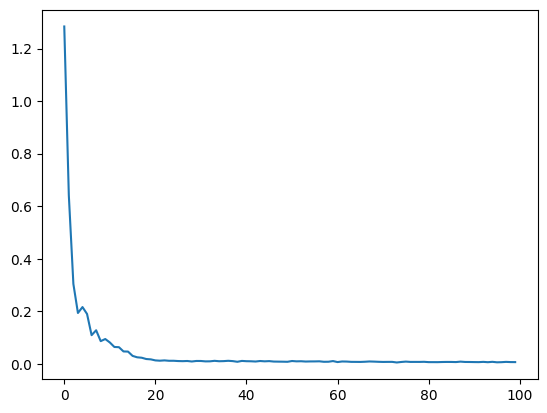

In [48]:
# plt.plot(history.history['loss'], label='loss')

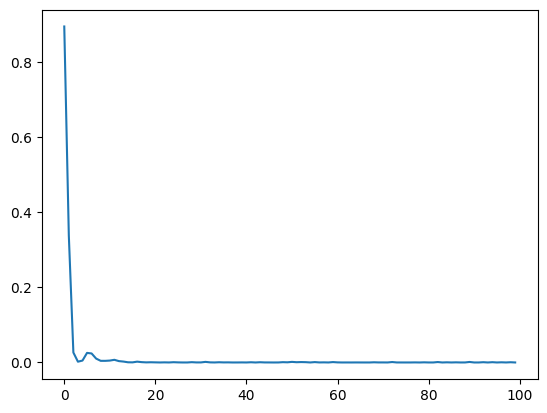

In [49]:
# plt.plot(history.history['val_loss'], label='val_loss')

In [50]:
# model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 3.3581e-05


[3.3581316529307514e-05, 0.0]

In [14]:
trainer = ModelTrainer(df2)

In [178]:
trainer.save_model()

AttributeError: 'ModelTrainer' object has no attribute 'model'

In [11]:
trainer.prepare_data('2023-01-03', '2023-01-05', ['close', 'high'], 3)

["2023-01-03", "2023-01-05", ["close", "high"]]
Using cached data


In [12]:
trainer.train_model(model, 1)

NameError: name 'model' is not defined

In [181]:
trainer.save_model()

AttributeError: 'ModelTrainer' object has no attribute 'model'

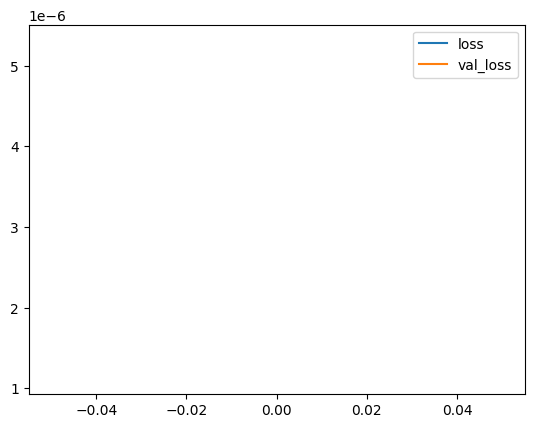

In [133]:
trainer.plot_loss()

In [174]:
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(3, 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))  # Predicting a single value

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [175]:
trainer.train_model(model1,1)

AttributeError: 'ModelTrainer' object has no attribute 'X_train'

In [137]:
trainer.save_model()

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=None.